## Elastic Aquifer Loading

This problem simulates elastic compaction of aquifer materials in response to the
loading of an aquifer by a passing train. Water-level responses were simulated for
an eastbound train leaving the Smithtown Station in Long Island, New York at 13:04
on April 23, 1937.

### Initial setup

Import dependencies, define the example name and workspace, and read settings from environment variables.

In [1]:
import datetime
import os
import pathlib as pl

import flopy
import git
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pooch
from flopy.plot.styles import styles
from modflow_devtools.misc import get_env, timed

# Example name and workspace paths. If this example is running
# in the git repository, use the folder structure described in
# the README. Otherwise just use the current working directory.
sim_name = "ex-gwf-csub-p01"
try:
    root = pl.Path(git.Repo(".", search_parent_directories=True).working_dir)
except:
    root = None
workspace = root / "examples" if root else pl.Path.cwd()
figs_path = root / "figures" if root else pl.Path.cwd()
data_path = root / "data" / sim_name if root else pl.Path.cwd()

# Settings from environment variables
write = get_env("WRITE", True)
run = get_env("RUN", True)
plot = get_env("PLOT", True)
plot_show = get_env("PLOT_SHOW", True)
plot_save = get_env("PLOT_SAVE", True)

### Define parameters

Define model units, parameters and other settings.

In [2]:
# Model units
length_units = "meters"
time_units = "seconds"

# Simulation starting date and time
dstart = datetime.datetime(1937, 4, 23, 13, 5, 55)

# Model parameters
nper = 2  # Number of periods
nlay = 3  # Number of layers
ncol = 35  # Number of columns
nrow = 1  # Number of rows
delr0 = 0.5  # Initial column width ($m$)
delrmax = 100.0  # Maximum column width
delc = 100.6  # Row width ($m$)
top = 0.0  # Top of the model ($ft$)
botm_str = "-12.2, -21.3, -30.5"  # Layer bottom elevations ($m$)
strt = -10.7  # Starting head ($m$)
icelltype_str = "1, 0, 0"  # Cell conversion type
k11_str = "1.8e-5, 3.5e-10, 3.1e-5"  # Horizontal hydraulic conductivity ($m/s$)
sy_str = "0.1, 0.05, 0.25"  # Specific yield (unitless)
sgm = 1.7  # Specific gravity of moist soils (unitless)
sgs = 2.0  # Specific gravity of saturated soils (unitless)
cg_ske_str = "3.3e-5, 6.6e-4, 4.5e-7"  # Coarse grained elastic storativity (1/$m$)
cg_theta_str = "0.25, 0.50, 0.30"  # Coarse-grained porosity (unitless)

# Create delr from delr0 and delrmac
delr = np.ones(ncol, dtype=float) * 0.5
xmax = delr[0]
for idx in range(1, ncol):
    dx = min(delr[idx - 1] * 1.2, 100.0)
    xmax += dx
    delr[idx] = dx

# Location of the observation well
locw201 = 11

# Load the aquifer load time series
fname = "train_load_193704231304.csv"
fpath = pooch.retrieve(
    url=f"https://github.com/MODFLOW-USGS/modflow6-examples/raw/master/data/{sim_name}/{fname}",
    fname=fname,
    path=data_path,
    known_hash="md5:32dc8e7b7e39876374af43605e264725",
)
csv_load = np.genfromtxt(fpath, names=True, delimiter=",")

# Reformat csv data into format for MODFLOW 6 timeseries file
csub_ts = []
for idx in range(csv_load.shape[0]):
    csub_ts.append((csv_load["sim_time"][idx], csv_load["load"][idx]))

# Static temporal data used by TDIS file
tdis_ds = (
    (0.5, 1, 1.0),
    (csv_load["sim_time"][-1] - 0.5, csv_load["sim_time"].shape[0] - 2, 1),
)

# Simulation starting date and time
dstart = datetime.datetime(1937, 4, 23, 13, 5, 55)

# Create a datetime list
date_list = [dstart + datetime.timedelta(seconds=x) for x in csv_load["sim_time"]]

# parse parameter strings into tuples
botm = [float(value) for value in botm_str.split(",")]
k11 = [float(value) for value in k11_str.split(",")]
icelltype = [int(value) for value in icelltype_str.split(",")]
sy = [float(value) for value in sy_str.split(",")]
cg_ske = [float(value) for value in cg_ske_str.split(",")]
cg_theta = [float(value) for value in cg_theta_str.split(",")]

# Solver parameters
nouter = 500
ninner = 300
hclose = 1e-9
rclose = 1e-6
linaccel = "bicgstab"
relax = 1.0

### Model setup

Define functions to build models, write input files, and run the simulation.

In [3]:
def build_models():
    sim_ws = os.path.join(workspace, sim_name)
    sim = flopy.mf6.MFSimulation(sim_name=sim_name, sim_ws=sim_ws, exe_name="mf6")
    flopy.mf6.ModflowTdis(sim, nper=nper, perioddata=tdis_ds, time_units=time_units)
    flopy.mf6.ModflowIms(
        sim,
        outer_maximum=nouter,
        outer_dvclose=hclose,
        linear_acceleration=linaccel,
        inner_maximum=ninner,
        inner_dvclose=hclose,
        relaxation_factor=relax,
        rcloserecord=f"{rclose} strict",
    )
    gwf = flopy.mf6.ModflowGwf(
        sim, modelname=sim_name, save_flows=True, newtonoptions="newton"
    )
    flopy.mf6.ModflowGwfdis(
        gwf,
        length_units=length_units,
        nlay=nlay,
        nrow=nrow,
        ncol=ncol,
        delr=delr,
        delc=delc,
        top=top,
        botm=botm,
    )
    obs_recarray = {"gwf_calib_obs.csv": [("w3_1_1", "HEAD", (2, 0, locw201))]}
    flopy.mf6.ModflowUtlobs(gwf, digits=10, print_input=True, continuous=obs_recarray)
    flopy.mf6.ModflowGwfic(gwf, strt=strt)
    flopy.mf6.ModflowGwfnpf(
        gwf,
        icelltype=icelltype,
        k=k11,
        save_specific_discharge=True,
    )
    flopy.mf6.ModflowGwfsto(
        gwf,
        iconvert=icelltype,
        ss=0.0,
        sy=sy,
        steady_state={0: True},
        transient={1: True},
    )
    csub = flopy.mf6.ModflowGwfcsub(
        gwf,
        print_input=True,
        update_material_properties=True,
        save_flows=True,
        ninterbeds=0,
        maxsig0=1,
        compression_indices=None,
        sgm=sgm,
        sgs=sgs,
        cg_theta=cg_theta,
        cg_ske_cr=cg_ske,
        beta=4.65120000e-10,
        packagedata=None,
        stress_period_data={0: [[(0, 0, 0), "LOAD"]]},
    )
    # initialize time series
    csubnam = f"{sim_name}.load.ts"
    csub.ts.initialize(
        filename=csubnam,
        timeseries=csub_ts,
        time_series_namerecord=["LOAD"],
        interpolation_methodrecord=["linear"],
        sfacrecord=["1.05"],
    )

    flopy.mf6.ModflowGwfoc(gwf, printrecord=[("BUDGET", "ALL")])
    return sim


def write_models(sim, silent=True):
    sim.write_simulation(silent=silent)


@timed
def run_models(sim, silent=True):
    success, buff = sim.run_simulation(silent=silent, report=True)
    assert success, buff

### Plotting results

Define functions to plot model results.

In [4]:
# Figure properties
figure_size = (6.8, 4.5)


def plot_results(sim, silent=True):
    with styles.USGSMap():
        gwf = sim.get_model(sim_name)

        # plot the grid
        fig = plt.figure(figsize=figure_size)
        gs = mpl.gridspec.GridSpec(10, 1, figure=fig)

        idx = 0
        ax = fig.add_subplot(gs[0:3])
        extent = (0, xmax, 0, 100)
        ax.set_ylim(0, 100)
        mm = flopy.plot.PlotMapView(model=gwf, ax=ax, extent=extent)
        mm.plot_grid(color="0.5", lw=0.5, zorder=100)
        ax.set_ylabel("y-coordinate,\nin meters")
        x, y = (
            gwf.modelgrid.xcellcenters[0, locw201],
            gwf.modelgrid.ycellcenters[0, 0],
        )
        ax.plot(x, y, marker="o", ms=4, zorder=100, mew=0.5, mec="black")
        ax.annotate(
            "Well S-201",
            xy=(x + 5, y),
            xytext=(x + 75, y),
            ha="left",
            va="center",
            zorder=100,
            arrowprops=dict(facecolor="black", shrink=0.05, headwidth=5, width=1.5),
        )
        styles.heading(ax, letter="A", heading="Map view")
        styles.remove_edge_ticks(ax)
        ax.axes.get_xaxis().set_ticks([])

        idx += 1
        ax = fig.add_subplot(gs[3:])
        extent = (0, xmax, botm[-1], 0)
        mc = flopy.plot.PlotCrossSection(
            model=gwf, line={"Row": 0}, ax=ax, extent=extent
        )
        ax.fill_between([0, delr.sum()], y1=top, y2=botm[0], color="cyan", alpha=0.5)
        ax.fill_between(
            [0, delr.sum()], y1=botm[0], y2=botm[1], color="#D2B48C", alpha=0.5
        )
        ax.fill_between(
            [0, delr.sum()], y1=botm[1], y2=botm[2], color="#00BFFF", alpha=0.5
        )
        mc.plot_grid(color="0.5", lw=0.5, zorder=100)
        ax.plot(
            [0, delr.sum()],
            [-35 / 3.28081, -35 / 3.28081],
            lw=0.75,
            color="black",
            ls="dashed",
        )
        ax.text(
            delr.sum() / 2, -10, "static water-level", va="bottom", ha="center", size=9
        )
        ax.set_ylabel("Elevation, in meters")
        ax.set_xlabel("x-coordinate, in meters")
        styles.heading(ax, letter="B", heading="Cross-section view")
        styles.remove_edge_ticks(ax)

        fig.align_ylabels()

        plt.tight_layout(pad=1, h_pad=0.001, rect=(0.005, -0.02, 0.99, 0.99))

        if plot_show:
            plt.show()
        if plot_save:
            fpth = figs_path / f"{sim_name}-grid.png"
            fig.savefig(fpth)

        # get the simulated heads
        sim_obs = gwf.obs.output.obs().data
        h0 = sim_obs["W3_1_1"][0]
        sim_obs["W3_1_1"] -= h0
        sim_date = [dstart + datetime.timedelta(seconds=x) for x in sim_obs["totim"]]

        # get the observed head
        fname = "s201_gw_2sec.csv"
        fpath = pooch.retrieve(
            url=f"https://github.com/MODFLOW-USGS/modflow6-examples/raw/master/data/{sim_name}/{fname}",
            fname=fname,
            path=data_path,
            known_hash="md5:1098bcd3f4fc1bd3b38d3d55152a8fbb",
        )
        dtype = [("date", object), ("dz_m", float)]
        obs_head = np.genfromtxt(fpath, names=True, delimiter=",", dtype=dtype)
        obs_date = []
        for s in obs_head["date"]:
            obs_date.append(
                datetime.datetime.strptime(s.decode("utf-8"), "%m-%d-%Y %H:%M:%S.%f")
            )
        t0, t1 = obs_date[0], obs_date[-1]

        # plot the results
        with styles.USGSPlot() as fs:
            fig = plt.figure(figsize=(6.8, 4.0))
            gs = mpl.gridspec.GridSpec(2, 1, figure=fig)

            axe = fig.add_subplot(gs[-1])

            idx = 0
            ax = fig.add_subplot(gs[idx], sharex=axe)
            ax.set_ylim(0, 3.25)
            ax.set_yticks(np.arange(0, 3.5, 0.5))
            ax.fill_between(
                date_list, csv_load["load"], y2=0, color="cyan", lw=0.5, alpha=0.5
            )
            ax.set_ylabel("Load, in meters\nof water")
            plt.setp(ax.get_xticklabels(), visible=False)
            styles.heading(ax, letter="A")
            styles.remove_edge_ticks(ax)

            ax = axe
            ax.plot(
                sim_date, sim_obs["W3_1_1"], color="black", lw=0.75, label="Simulated"
            )
            ax.plot(
                obs_date,
                obs_head["dz_m"],
                color="red",
                lw=0,
                ms=4,
                marker=".",
                label="Offset S-201",
            )
            ax.axhline(0, lw=0.5, color="0.5")
            ax.set_ylabel("Water level fluctuation,\nin meters")
            styles.heading(ax, letter="B")
            leg = styles.graph_legend(ax, loc="upper right", ncol=1)

            ax.set_xlabel("Time")
            ax.set_ylim(-0.004, 0.008)
            axe.set_xlim(t0, t1)
            styles.remove_edge_ticks(ax)

            fig.align_ylabels()

            plt.tight_layout(pad=1, h_pad=0.001, rect=(0.005, -0.02, 0.99, 0.99))

            if plot_show:
                plt.show()
            if plot_save:
                fpth = figs_path / f"{sim_name}-01.png"
                fig.savefig(fpth)

### Running the example

Define and invoke a function to run the example scenario, then plot results.

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing solution package ims_-1...
  writing model ex-gwf-csub-p01...
    writing model name file...
    writing package dis...
    writing package obs_0...
    writing package ic...
    writing package npf...
    writing package sto...
    writing package csub...
    writing package ts_0...
    writing package oc...
FloPy is using the following executable to run the model: ../../../../../../.local/bin/modflow/mf6
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.6.1 02/07/2025
                               ***DEVELOP MODE***

        MODFLOW 6 compiled Feb  8 2025 12:33:09 with GCC version 13.3.0

This software has been approved for release by the U.S. Geological 
Survey (USGS). Although the software has been subjected to rigorous 
review, the USGS reserves the right to update the software as ne

    Solving:  Stress period:     2    Time step:   101
    Solving:  Stress period:     2    Time step:   102
    Solving:  Stress period:     2    Time step:   103
    Solving:  Stress period:     2    Time step:   104
    Solving:  Stress period:     2    Time step:   105
    Solving:  Stress period:     2    Time step:   106
    Solving:  Stress period:     2    Time step:   107
    Solving:  Stress period:     2    Time step:   108
    Solving:  Stress period:     2    Time step:   109
    Solving:  Stress period:     2    Time step:   110
    Solving:  Stress period:     2    Time step:   111
    Solving:  Stress period:     2    Time step:   112
    Solving:  Stress period:     2    Time step:   113
    Solving:  Stress period:     2    Time step:   114
    Solving:  Stress period:     2    Time step:   115
    Solving:  Stress period:     2    Time step:   116
    Solving:  Stress period:     2    Time step:   117

 Run end date and time (yyyy/mm/dd hh:mm:ss): 2025/02/08 12:34:2

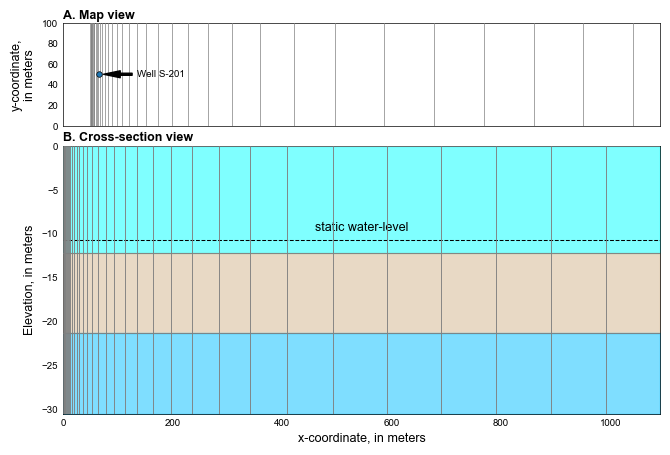

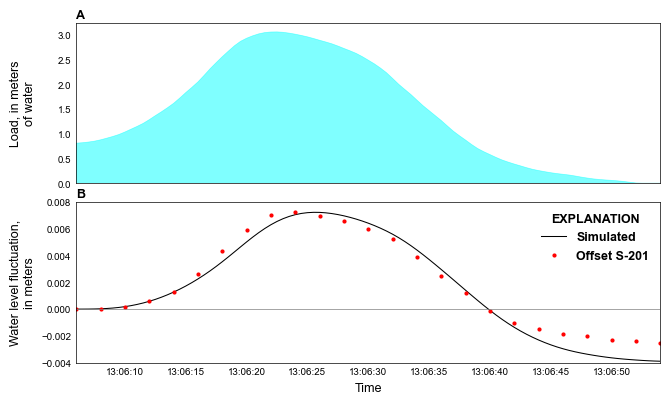

In [5]:
def scenario(silent=True):
    sim = build_models()
    if write:
        write_models(sim, silent=silent)
    if run:
        run_models(sim, silent=silent)
    if plot:
        plot_results(sim, silent=silent)


scenario(silent=False)